<a href="https://colab.research.google.com/github/sgspencer2618/xgboost-options-pricing/blob/main/options_pricer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $AAPL Stock Price Buy-Sell Signal Prediction Based on Options Price Behaviour Using Gradient-Boosted Trees ([XGBoost](https://xgboost.readthedocs.io/en/latest/#))

Using the datasets below, the model is trained on options chain data of the $AAPL (Apple) stock from Q1 2016 to Q1 2023, through gradient boosted trees implemented using the XGBoost library.

Options Chains Dataset:
https://www.kaggle.com/datasets/kylegraupe/aapl-options-data-2016-2020/data

Stock Price Dataset:
https://www.kaggle.com/datasets/muhammadbilalhaneef/-apple-stock-prices-from-1981-to-2023


In [ ]:
# Importing libraries and dependencies
!pip install scikit-learn==1.2.2

# Data Cleaning, Graphing, and XGBoost
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Bayesian Optimization
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.model_selection import TimeSeriesSplit

# Finance
!pip install mplfinance
import mplfinance as mpf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 74.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.8 MB/s eta 0:00:00


In [ ]:
# Defining constants

# Feature columns for model training
FEATURE_COLS = [
    'UNDERLYING_LAST',
    'DTE',
    'C_DELTA',
    'C_GAMMA',
    'C_VEGA',
    'C_THETA',
    'C_RHO',
    'C_IV',
    'C_VOLUME',
    'C_BID',
    'C_ASK',
    'STRIKE_DISTANCE',
    'STRIKE_DISTANCE_PCT',
    'MONEYNESS'
]

# Start, end, and split dates for training data
TRAIN_END_DATE = '2021-08-01'
TRAIN_SPLIT_DATE = '2018-07-03'

# Start, and end dates for signal prediction
PRED_START_DATE = '2022-08-01'
PRED_END_DATE = '2023-01-01'

## Training the XGBoost Model


In [ ]:
# Defining a function to assist with data cleaning
def prepare_data(df):
  """
  Properly formats column names, adds a column for moneyness (calculated as the
  ratio of the underlying last / strike price), and replaces all whitespace
  entries with NaN.
  """
  new_column_names = [x.strip()[1:len(x.strip()) - 1] for x in df.columns]
  df.columns = new_column_names

  df['MONEYNESS'] = df['UNDERLYING_LAST'] / df['STRIKE']
  df = df.replace(' ', np.nan)
  return df

In [ ]:
# Loading data into a dataframe
df = pd.read_csv('options_data/aapl_2016_2020.csv')
df = prepare_data(df)
df.head()

# Preparing a portion of the second dataset to be appended (before august 2021)
# to provide additional training data
df2 = pd.read_csv('options_data/aapl_2021_2023.csv')
df2 = prepare_data(df2)
df2 = df2[df2['QUOTE_DATE'] < TRAIN_END_DATE]
df2.head()

# Appending the additional data
df = pd.concat([df, df2], axis=0, ignore_index=True)
df.head()

<ipython-input-4-5556d6104915>:2: DtypeWarning: Columns (8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('options_data/aapl_2016_2020.csv')
<ipython-input-4-5556d6104915>:8: DtypeWarning: Columns (15,17,18,20,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('options_data/aapl_2021_2023.csv')


,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,MONEYNESS
0,1546462800,2019-01-02 16:00,2019-01-02,16.0,157.92,2019-01-04,1546635600,2.0,0.90886,0.00019,...,-0.00034,0.00011,0.00079,-0.00509,-0.00041,1.625550,0.000000,57.9,0.367,1.579200
1,1546462800,2019-01-02 16:00,2019-01-02,16.0,157.92,2019-01-04,1546635600,2.0,1.0,0.0,...,-0.00069,0.0001,0.00039,-0.00518,-0.0001,1.461900,200.000000,52.9,0.335,1.504000
2,1546462800,2019-01-02 16:00,2019-01-02,16.0,157.92,2019-01-04,1546635600,2.0,1.0,0.0,...,-0.00066,0.0002,0.0,-0.00425,-0.00009,1.305490,706.000000,47.9,0.303,1.435636
3,1546462800,2019-01-02 16:00,2019-01-02,16.0,157.92,2019-01-04,1546635600,2.0,1.0,0.0,...,-0.0012,0.00021,0.00089,-0.00434,-0.00005,1.155130,0.000000,42.9,0.272,1.373217
4,1546462800,2019-01-02 16:00,2019-01-02,16.0,157.92,2019-01-04,1546635600,2.0,1.0,0.0,...,-0.00109,0.00024,0.00045,-0.00429,-0.0002,1.010620,0.000000,37.9,0.240,1.316000


In [ ]:
# Defining a helper to assist with resetting indices of train and test subsets
def index_reset(x_subset, y_subset):
  x_subset = x_subset.reset_index(drop=True)
  y_subset = y_subset.reset_index(drop=True)

In [ ]:
# Defining a function to assist with time series train-test splitting
def train_test_split(df, split_date):
  df_train = df.loc[df['QUOTE_DATE'] < split_date]
  df_train = df_train.dropna()
  x_train = df_train[feature_cols]
  y_train = df_train['C_LAST']


  df_test = df.loc[df['QUOTE_DATE'] >= split_date]
  df_test = df_test.dropna()
  x_test = df_test[feature_cols]
  y_test = df_test['C_LAST']

  return x_train, y_train, x_test, y_test

In [ ]:
# Defining feature columns

feature_cols = FEATURE_COLS

# Converting the QUOTE_DATE column into the datetime datatype
df['QUOTE_DATE'] = pd.to_datetime(df['QUOTE_DATE'])

# Using helper function train_test_split() to split data into training and
# testing subsets
x_train, y_train, x_test, y_test = train_test_split(df, TRAIN_SPLIT_DATE)

index_reset(x_train, y_train)
y_train = y_train[y_train.index.isin(x_train.index)]
index_reset(x_train, y_train)

index_reset(x_test, y_test)
y_test = y_test[y_test.index.isin(x_test.index)]
index_reset(x_test, y_test)


In [ ]:
# Ensuring correct datatypes

for col in ['C_IV', 'C_VOLUME', 'C_BID', 'C_ASK', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO']:
  print(x_train.shape)
  print(x_train[col].shape)

  x_train[col] = pd.to_numeric(x_train[col], errors='coerce')
  x_test[col] = pd.to_numeric(x_test[col], errors='coerce')

(130200, 14)
(130200,)
(130200, 14)
(130200,)
(130200, 14)
(130200,)
(130200, 14)
(130200,)
(130200, 14)
(130200,)
(130200, 14)
(130200,)
(130200, 14)
(130200,)
(130200, 14)
(130200,)
(130200, 14)
(130200,)


In [ ]:
# hyperparameter tuning using bayesian optimisation

search_spaces = {
    'max_depth': Integer(3, 6),
    'learning_rate': Real(1e-3, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'reg_alpha': Real(0, 10),
    'reg_lambda': Real(0, 10),
    'n_estimators': Integer(100, 500)
}

model = XGBRegressor(objective='reg:squarederror',
    random_state=42
)

tss = TimeSeriesSplit(n_splits=3)

bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=10,                   # number of parameter settings to try
    scoring='neg_mean_squared_error',
    cv=tss,
    verbose=1,
    random_state=42
)

y_train = pd.to_numeric(y_train, errors='coerce')

bayes_search.fit(x_train, y_train)

print("Best Score:", bayes_search.best_score_)
print("Best Params:", bayes_search.best_params_)


# model.fit(x_train, y_train,
#           eval_set=[(x_test, y_test)],  # so we can see progress on test set
#           verbose=True)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Score: -0.4069952583656072
Best Params: OrderedDict([('colsample_bytree', 0.9777389931549642), ('learning_rate', 0.054390652888685394), ('max_depth', 6), ('n_estimators', 266), ('reg_alpha', 3.8106476479749283), ('reg_lambda', 2.1141428727419624), ('subsample', 0.5000305253763367)])


In [ ]:
best_model = bayes_search.best_estimator_

In [ ]:
y_pred = best_model.predict(x_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2  = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")


Mean Absolute Error: 4.4466
Mean Squared Error: 206.5355
RMSE: 14.3713
R^2: 0.9006


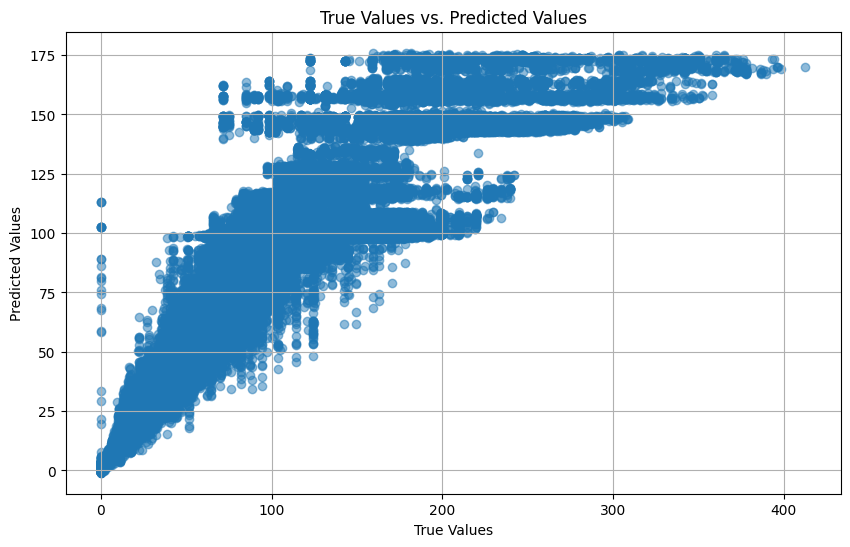

In [ ]:
# Plotting the predicted value against the true value to evaluate predictive
# behaviour

plt.figure(figsize=(10, 6))

y_test = pd.to_numeric(y_test, errors='coerce')
y_pred = pd.to_numeric(y_pred, errors='coerce')


plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True Values vs. Predicted Values")

plt.grid(True)
plt.show()

In [ ]:
# Calculating residuals
residuals = pd.to_numeric(y_test, errors='coerce') - y_pred
print(residuals)

0         -0.978894
14        -1.449491
20        -1.099849
26        -1.957872
27        -1.506814
             ...   
1563501    0.178429
1563502    0.623571
1563503    0.005637
1563504    0.915261
1563505   -0.789544
Name: C_LAST, Length: 741882, dtype: float64


In [ ]:
# Saving most optimal model
best_model.save_model("options_model.json")

## Using the Trained Model to Generate Buy/Sell Signals



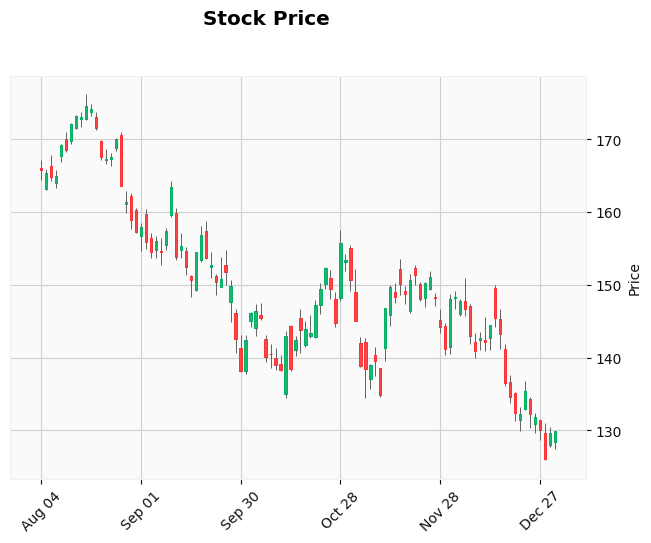

In [ ]:
df_price = pd.read_csv('options_data/aapl_stock_prices.csv', parse_dates=['Date'])
df_price.head()

df_price['Date'] = pd.to_datetime(df_price['Date'], format='%d/%m/%Y')

start_date = pd.to_datetime(PRED_START_DATE)
end_date = pd.to_datetime(PRED_END_DATE)

df_price = df_price[(df_price['Date'] >= start_date) & (df_price['Date'] <= end_date)]

df_price.set_index('Date', inplace=True)

mpf.plot(
    df_price,
    type='candle',
    style='yahoo',
    # volume=True,          # add volume subplot
    title='Stock Price',
    # mav=(20, 50),         # plot 20 & 50 day moving averages
    show_nontrading=False
)

In [ ]:
# Loading optimal model
# Comment this out if you would like to use the retrained model
model = XGBRegressor()
model.load_model("options_model.json")

In [ ]:
# Using retrained model
# Comment out if you want to use a pretrained model (run the cell above instead)
# model = best_model

In [ ]:
# Loading and preparing new data

df_new = pd.read_csv('options_data/aapl_2021_2023.csv')
df_new = prepare_data(df_new)
df_new.head()


feature_cols = FEATURE_COLS

# target
y = df_new['C_LAST']

# features
x = df_new[feature_cols]

x = x.dropna()
y = y[x.index]

for col in ['C_IV', 'C_VOLUME', 'C_BID', 'C_ASK', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO']:
    x[col] = pd.to_numeric(x[col], errors='coerce')

<ipython-input-30-81bfe2132824>:3: DtypeWarning: Columns (15,17,18,20,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv('options_data/aapl_2021_2023.csv')
<ipython-input-30-81bfe2132824>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[col] = pd.to_numeric(x[col], errors='coerce')


In [ ]:
mask = x.isnull().any(axis=1)
x = x[~mask]
y = y[~mask]

# Predicting on the cleaned data
df_new['C_LAST_PREDICTED'] = np.nan  # Initialize the new column with NaNs
df_new.loc[x.index, 'C_LAST_PREDICTED'] = model.predict(x)

print(df_new[['UNDERLYING_LAST', 'C_LAST', 'C_LAST_PREDICTED']])

        UNDERLYING_LAST      C_LAST  C_LAST_PREDICTED
0                138.90    0.000000               NaN
1                138.90    0.000000               NaN
2                138.90    0.000000               NaN
3                138.90   53.160000         55.219139
4                138.90   47.300000         49.102676
...                 ...         ...               ...
548158           138.09         4.4          3.706005
548159           138.09        4.31          3.495901
548160           138.09        3.75          2.810736
548161           138.09         2.3          2.115693
548162           138.09        2.15          1.941280

[548163 rows x 3 columns]


In [ ]:
# Converting 'C_LAST' column to numeric for calculation
df_new['C_LAST'] = pd.to_numeric(df_new['C_LAST'], errors='coerce')

# Buy and sell thresholds
buy_threshold = 0.012
sell_threshold = -0.012

# Define the signal conditions
conditions = [
    df_new['C_LAST_PREDICTED'] > df_new['C_LAST'] * (1 + buy_threshold),
    df_new['C_LAST_PREDICTED'] < df_new['C_LAST'] * (1 + sell_threshold)
]
choices = ['Buy', 'Sell']

# np.select picks the first matching condition, defaulting to 'Hold' otherwise
df_new['signal'] = np.select(conditions, choices, default='Hold')

In [ ]:
# Displaying new column
df_new.sort_values(by=['QUOTE_DATE'], inplace=True)
df_new.head()

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,MONEYNESS,C_LAST_PREDICTED,signal
381554,1609794000,2021-01-04 16:00,2021-01-04,16.0,129.45,2021-01-08,1610139600,4.00,1.00000,0.00000,...,0.00026,-0.00351,0.00000,1.886900,0.000000,64.4,0.498,1.991538,NaN,Hold
382248,1609794000,2021-01-04 16:00,2021-01-04,16.0,129.45,2021-07-16,1626465600,192.96,0.12884,0.00574,...,0.22479,-0.02387,-0.48982,0.411880,NaN,55.6,0.429,0.699730,2.128225,Buy
382249,1609794000,2021-01-04 16:00,2021-01-04,16.0,129.45,2021-07-16,1626465600,192.96,0.11353,0.00522,...,0.21651,-0.02350,-0.47589,0.425210,0.000000,60.6,0.468,0.681316,1.855854,Buy
382250,1609794000,2021-01-04 16:00,2021-01-04,16.0,129.45,2021-07-16,1626465600,192.96,0.10019,0.00472,...,0.20933,-0.02370,-0.45818,0.435870,1.000000,65.6,0.506,0.663846,1.611984,Buy
382251,1609794000,2021-01-04 16:00,2021-01-04,16.0,129.45,2021-07-16,1626465600,192.96,0.08985,0.00423,...,0.20763,-0.02403,-0.45082,0.456590,1.000000,70.6,0.545,0.647250,1.457048,Buy


In [ ]:
# Parsing and graphing prices of stocks within given timeframe for prediction
df_price = pd.read_csv('options_data/aapl_stock_prices.csv', parse_dates=['Date'])
df_price.head()

df_price['Date'] = pd.to_datetime(df_price['Date'], format='%d/%m/%Y')

# Start and end dates for prediction
start_date = pd.to_datetime(PRED_START_DATE)
end_date = pd.to_datetime(PRED_END_DATE)

df_price = df_price[(df_price['Date'] >= start_date) & (df_price['Date'] <= end_date)]
df_price.head()

df_new['QUOTE_DATE'] = pd.to_datetime(df_new['QUOTE_DATE'])
df_new.set_index('QUOTE_DATE', inplace=True)

In [ ]:
df_new.head()

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,C_VEGA,...,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,MONEYNESS,C_LAST_PREDICTED,signal
QUOTE_DATE,,,,,,,,,,,,,,,,,,,,,
2021-01-04,1609794000,2021-01-04 16:00,16.0,129.45,2021-01-08,1610139600,4.00,1.00000,0.00000,0.00000,...,0.00026,-0.00351,0.00000,1.886900,0.000000,64.4,0.498,1.991538,NaN,Hold
2021-01-04,1609794000,2021-01-04 16:00,16.0,129.45,2021-07-16,1626465600,192.96,0.12884,0.00574,0.19817,...,0.22479,-0.02387,-0.48982,0.411880,NaN,55.6,0.429,0.699730,2.128225,Buy
2021-01-04,1609794000,2021-01-04 16:00,16.0,129.45,2021-07-16,1626465600,192.96,0.11353,0.00522,0.18080,...,0.21651,-0.02350,-0.47589,0.425210,0.000000,60.6,0.468,0.681316,1.855854,Buy
2021-01-04,1609794000,2021-01-04 16:00,16.0,129.45,2021-07-16,1626465600,192.96,0.10019,0.00472,0.16665,...,0.20933,-0.02370,-0.45818,0.435870,1.000000,65.6,0.506,0.663846,1.611984,Buy
2021-01-04,1609794000,2021-01-04 16:00,16.0,129.45,2021-07-16,1626465600,192.96,0.08985,0.00423,0.15250,...,0.20763,-0.02403,-0.45082,0.456590,1.000000,70.6,0.545,0.647250,1.457048,Buy


In [ ]:
# Initializing flag dataframe
dates = []
signals = []

for date in df_price['Date']:
  dates.append(date)

  if date in df_new.index:
      daily_signals = df_new.loc[date, 'signal'].tolist()

      if isinstance(daily_signals, str):
          most_common_flag = daily_signals
      else:
          most_common_flag = max(set(daily_signals), key=daily_signals.count)
  else:
      # If the date is not in df_new, assign it the default value of 'Hold'
      most_common_flag = 'None'

  signals.append(most_common_flag)


print(signals)

print(len(dates))
print(len(signals))

if (len(dates) == len(signals)):
  print("Success: number of dates and number of signals align.")

df_signals = pd.DataFrame({
    'Date': dates,
    'Signal': signals
})

df_merged = df_price.merge(df_signals, on='Date', how='left')
df_merged['Signal'] = df_merged['Signal'].fillna('None')

df_merged.set_index('Date', inplace=True)

df_merged.head()

['Hold', 'Buy', 'Sell', 'Sell', 'Buy', 'Hold', 'Buy', 'Hold', 'Buy', 'Hold', 'Hold', 'Sell', 'Sell', 'Sell', 'Sell', 'Buy', 'Sell', 'Sell', 'Buy', 'Sell', 'Buy', 'Buy', 'Buy', 'Buy', 'Sell', 'Buy', 'Buy', 'Sell', 'Buy', 'Sell', 'Buy', 'Buy', 'Buy', 'Sell', 'Sell', 'Buy', 'Sell', 'Buy', 'Sell', 'Buy', 'Sell', 'Buy', 'Buy', 'Sell', 'Sell', 'Buy', 'Sell', 'Sell', 'Sell', 'Buy', 'Sell', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Sell', 'Sell', 'Buy', 'Buy', 'Sell', 'Sell', 'Sell', 'Buy', 'Sell', 'Sell', 'Sell', 'Buy', 'Buy', 'Sell', 'Sell', 'Sell', 'Buy', 'Sell', 'Sell', 'Buy', 'Buy', 'Sell', 'Sell', 'Buy', 'Buy', 'Sell', 'Buy', 'Sell', 'Buy', 'Buy', 'Buy', 'Sell', 'Buy', 'Sell', 'Sell', 'Sell', 'None', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Buy']
104
104
Success: number of dates and number of signals align.


,Open,High,Low,Close,Adj Close,Volume,Signal
Date,,,,,,,
2022-08-04,166.009995,167.190002,164.429993,165.809998,165.305786,55474100,Hold
2022-08-05,163.210007,165.850006,163.000000,165.350006,165.076172,56697000,Buy
2022-08-08,166.369995,167.809998,164.199997,164.869995,164.596954,60276900,Sell
2022-08-09,164.020004,165.820007,163.250000,164.919998,164.646866,63135500,Sell
2022-08-10,167.679993,169.339996,166.899994,169.240005,168.959732,70170500,Buy


# Presenting the Final Overlaid Graph of Stock Price

In [ ]:
# Define dataframes to hold all Buy and Sell rows respectively, ignoring
# Hold rows
buy_signals = df_merged[df_merged['Signal']=='Buy']
sell_signals = df_merged[df_merged['Signal']=='Sell']

# Padding dataframes to match sizes and indices
buy_signals_padded = buy_signals.reindex(df_merged.index)
sell_signals_padded = sell_signals.reindex(df_merged.index)

# Defining overlay onto price plot
apds = [
    mpf.make_addplot(buy_signals_padded['Close'], type='scatter', marker='^', color='g', panel=0),
    mpf.make_addplot(sell_signals_padded['Close'], type='scatter', marker='v', color='r', panel=0)
]

Below is the final plot of the model's predictions:

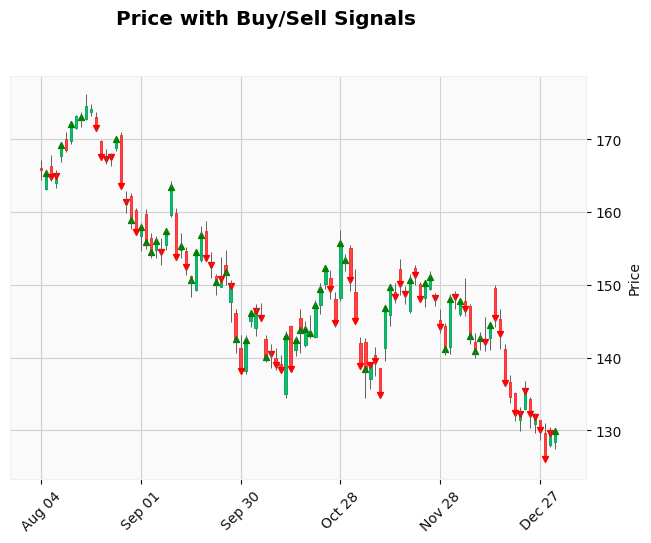

In [ ]:
# Plotting the price and signals from the model's predictions
mpf.plot(
    df_merged,
    type='candle',
    style='yahoo',
    addplot=apds,
    title='Price with Buy/Sell Signals'
)